In [1]:
import sys
sys.path.append('../')

In [2]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns
import shap
from lightgbm import LGBMClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, top_k_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier

from src.constants import FEATURE_COLUMNS, LABEL, KNOWN_CLASSES, RESULT_DIR

/home/jiawei/deepmir_hw0/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Prepare Data

In [3]:
train_df = pd.read_csv('../dataset/train.csv')
test_df = pd.read_csv('../dataset/test.csv')

train_wavlm_df = pd.read_csv('../dataset/train_wavlm.csv')
test_wavlm_df = pd.read_csv('../dataset/test_wavlm.csv')

In [4]:
wavlm_feature_columns = [c for c in train_wavlm_df.columns if 'wavlm' in c]

In [5]:
X_train = train_df[FEATURE_COLUMNS].to_numpy()
y_train = train_df[LABEL].to_numpy()

X_test = test_df[FEATURE_COLUMNS].to_numpy()
y_test = test_df[LABEL].to_numpy()

X_train_wavlm = train_wavlm_df[wavlm_feature_columns].to_numpy()
X_test_wavlm = test_wavlm_df[wavlm_feature_columns].to_numpy()

## Use PCA to Reduce WavLM Features Dimension

In [6]:
pca = PCA(n_components=100)

X_train_wavlm_pca = pca.fit_transform(X_train_wavlm)
X_test_wavlm_pca = pca.transform(X_test_wavlm)

model = LGBMClassifier(n_estimators=400, random_state=42)
model.fit(X_train_wavlm_pca, y_train)
y_pred = model.predict(X_test_wavlm_pca)

top1_acc = accuracy_score(y_test, y_pred)
top3_acc = top_k_accuracy_score(y_test, model.predict_proba(X_test_wavlm_pca), k=3, labels=KNOWN_CLASSES)
print(f"Top-1 Accuracy: {top1_acc * 100:.2f}%")
print(f"Top-3 Accuracy: {top3_acc * 100:.2f}%")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 48037, number of used features: 100
[LightGBM] [Info] Start training from score -2.261534
[LightGBM] [Info] Start training from score -2.644966
[LightGBM] [Info] Start training from score -2.456604
[LightGBM] [Info] Start training from score -2.338767
[LightGBM] [Info] Start training from score -2.360146
[LightGBM] [Info] Start training from score -2.329956
[LightGBM] [Info] Start training from score -2.368116
[LightGBM] [Info] Start training from score -2.429297
[LightGBM] [Info] Start training from score -2.529107
[LightGBM] [Info] Start training from score -2.350273
[LightGBM] [Info] Start training from score -2.363460
Top-1 Accuracy: 60.67%
Top-3 Accuracy: 84.28%


In [7]:
pca = PCA(n_components=20)

pca.fit(X_train_wavlm)
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio_cumsum = np.cumsum(pca.explained_variance_ratio_)

print("Explained variance ratio :\n", explained_variance_ratio)
print("Cumsum of explained variance ratio:\n", explained_variance_ratio_cumsum)

Explained variance ratio :
 [0.39691512 0.11586596 0.07690053 0.06865934 0.03821662 0.03417514
 0.02915265 0.0237955  0.02108294 0.01745355 0.0146484  0.01233415
 0.01076056 0.01013717 0.00879752 0.00784713 0.0062089  0.0057985
 0.00523667 0.00423146]
Cumsum of explained variance ratio:
 [0.39691512 0.51278108 0.58968161 0.65834095 0.69655756 0.73073271
 0.75988536 0.78368087 0.80476381 0.82221736 0.83686576 0.84919991
 0.85996047 0.87009764 0.87889517 0.8867423  0.8929512  0.8987497
 0.90398637 0.90821783]


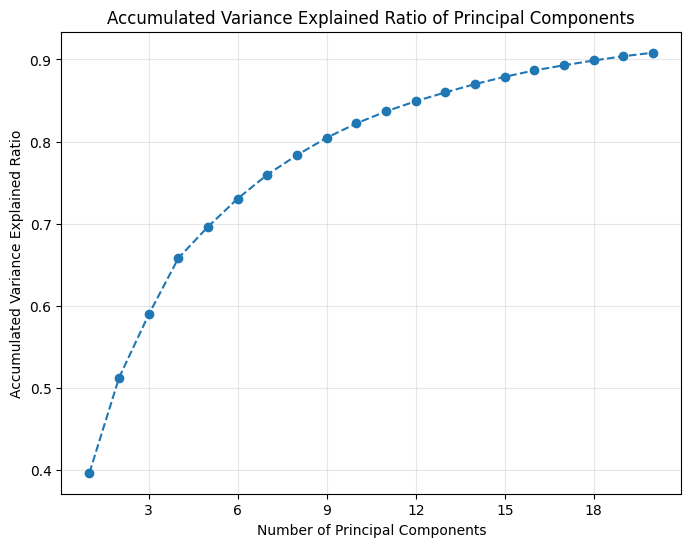

In [8]:
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(explained_variance_ratio_cumsum) + 1), explained_variance_ratio_cumsum, marker='o', linestyle='--')
plt.title('Accumulated Variance Explained Ratio of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Accumulated Variance Explained Ratio')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.grid(alpha=0.3)
plt.show()

In [9]:
pca = PCA(n_components=9)

X_train_wavlm_pca = pca.fit_transform(X_train_wavlm)
X_test_wavlm_pca = pca.transform(X_test_wavlm)

model = LGBMClassifier(n_estimators=400, random_state=42)
model.fit(X_train_wavlm_pca, y_train)
y_pred = model.predict(X_test_wavlm_pca)

top1_acc = accuracy_score(y_test, y_pred)
top3_acc = top_k_accuracy_score(y_test, model.predict_proba(X_test_wavlm_pca), k=3, labels=KNOWN_CLASSES)
print(f"Top-1 Accuracy: {top1_acc * 100:.2f}%")
print(f"Top-3 Accuracy: {top3_acc * 100:.2f}%")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 48037, number of used features: 9
[LightGBM] [Info] Start training from score -2.261534
[LightGBM] [Info] Start training from score -2.644966
[LightGBM] [Info] Start training from score -2.456604
[LightGBM] [Info] Start training from score -2.338767
[LightGBM] [Info] Start training from score -2.360146
[LightGBM] [Info] Start training from score -2.329956
[LightGBM] [Info] Start training from score -2.368116
[LightGBM] [Info] Start training from score -2.429297
[LightGBM] [Info] Start training from score -2.529107
[LightGBM] [Info] Start training from score -2.350273
[LightGBM] [Info] Start training from score -2.363460
Top-1 Accuracy: 43.19%
Top-3 Accuracy: 75.93%


## Combine the Signal Features and WavLM features

In [10]:
X_train = np.hstack([X_train, X_train_wavlm_pca])
X_test = np.hstack([X_test, X_test_wavlm_pca])
X_train.shape

(48037, 80)

In [15]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

top1_acc = accuracy_score(y_test, y_pred)
top3_acc = top_k_accuracy_score(y_test, model.predict_proba(X_test), k=3, labels=KNOWN_CLASSES)
print(f"Top-1 Accuracy: {top1_acc * 100:.2f}%")
print(f"Top-3 Accuracy: {top3_acc * 100:.2f}%")

Top-1 Accuracy: 68.99%
Top-3 Accuracy: 87.92%


## Ensemble

In [12]:
estimators = [
    ('lgbm', LGBMClassifier(n_estimators=400, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=400, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=150, random_state=42)),
]

voting_model = VotingClassifier(
    estimators=estimators,
    voting='soft',
)
voting_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20275
[LightGBM] [Info] Number of data points in the train set: 48037, number of used features: 80
[LightGBM] [Info] Start training from score -2.261534
[LightGBM] [Info] Start training from score -2.644966
[LightGBM] [Info] Start training from score -2.456604
[LightGBM] [Info] Start training from score -2.338767
[LightGBM] [Info] Start training from score -2.360146
[LightGBM] [Info] Start training from score -2.329956
[LightGBM] [Info] Start training from score -2.368116
[LightGBM] [Info] Start training from score -2.429297
[LightGBM] [Info] Start training from score -2.529107
[LightGBM] [Info] Start training from score -2.350273
[LightGBM] [Info] Start training from score -2.363460


VotingClassifier(estimators=[('lgbm',
                              LGBMClassifier(n_estimators=400,
                                             random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            imp...
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=400, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('rf',
                              RandomForestClassifier(n_estimators=150,
                                                     random_state=42))],
                 voting='soft')

In [13]:
y_pred = voting_model.predict(X_test)

top1_acc = accuracy_score(y_test, y_pred)
top3_acc = top_k_accuracy_score(y_test, voting_model.predict_proba(X_test), k=3, labels=KNOWN_CLASSES)
print(f"Top-1 Accuracy: {top1_acc * 100:.2f}%")
print(f"Top-3 Accuracy: {top3_acc * 100:.2f}%")

Top-1 Accuracy: 71.92%
Top-3 Accuracy: 89.33%
